1. Import depencencies

In [5]:
!pip install opencv-python, numpy, matplotlib

ERROR: Invalid requirement: 'opencv-python,'

[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [226]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import random


In [227]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Layer
import tensorflow as tf

1.1 GPU growth

In [228]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

1.4 Folder Structures

In [229]:
pos_path = os.path.join('data','positive')
neg_path = os.path.join('data','negative')
anc_path = os.path.join('data','anchor')


In [230]:
os.makedirs(pos_path, exist_ok=True)
os.makedirs(neg_path, exist_ok=True)    
os.makedirs(anc_path, exist_ok=True)

2. Collect Positve and Anchor

In [35]:
#Move LFW to folder repository 
for directory in os.listdir('lfw\lfw-deepfunneled'):
    dir_path = os.path.join('lfw\lfw-deepfunneled', directory)
    if os.path.isdir(dir_path):
        for file in os.listdir(os.path.join('lfw\lfw-deepfunneled', directory)):
            print(os.path.join('lfw\lfw-deepfunneled', directory, file))
            ex_path = os.path.join('lfw/lfw-deepfunneled', directory, file)
            new_path = os.path.join(neg_path,file)
            os.replace(ex_path, new_path)


In [231]:
import uuid

In [ ]:
cap =cv2.VideoCapture(4)
while cap.isOpened():
    ret, frame = cap.read()

    frame = frame[120:120+250, 120:120+250,:]
    #collect anchors
    if cv2.waitKey(1) & 0xFF == ord('a'):
        img_name = os.path.join(anc_path,'{}.jpg'.format(uuid.uuid1()))
        cv2.imwrite(img_name, frame)
    #collect positve  
    if cv2.waitKey(1) & 0xFF == ord('p'):
        img_name = os.path.join(pos_path,'{}.jpg'.format(uuid.uuid1()))
        cv2.imwrite(img_name, frame)
    cv2.imshow('frame', frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

3. Load the preprocess Images

In [232]:
anchor = tf.data.Dataset.list_files(anc_path + '\*.jpg').take(300)
positive = tf.data.Dataset.list_files(pos_path + '\*.jpg').take(300)
negative = tf.data.Dataset.list_files(neg_path + '\*.jpg').take(300)

In [212]:
dir_test = anchor.as_numpy_iterator()

In [213]:
dir_test.next()

b'data\\anchor\\4213f492-1833-11f0-84d4-bceca0050205.jpg'

3.1 Preprocess ( Scale and resize)

In [233]:
def preprocess(file_path):
    image = tf.io.read_file(file_path)
    image = tf.io.decode_jpeg(image)
    image = tf.image.resize(image, (100, 100))
    image =image/255.0
    return image

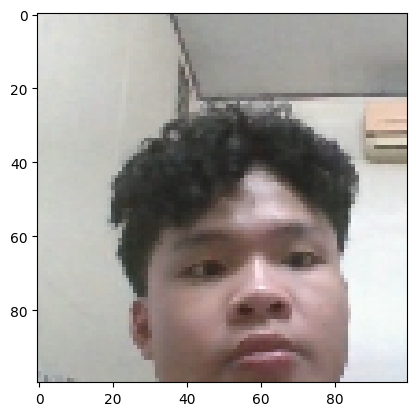

In [162]:
img = preprocess('data\\anchor\\4cf0c885-116a-11f0-8225-c85ea9f45b27.jpg')
plt.imshow(img)

3.3 Create Labelled Dataset

anchor, positive

In [234]:
postive = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negative = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = postive.concatenate(negative)

In [44]:
data

<_ConcatenateDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>

In [164]:
samples = data.as_numpy_iterator()
samples.next()

(b'data\\anchor\\831b5399-11cc-11f0-8f51-c85ea9f45b27.jpg',
 b'data\\positive\\7ca15bca-11cc-11f0-9214-c85ea9f45b27.jpg',
 1.0)

In [165]:
examples = samples.next()
examples

(b'data\\anchor\\42c0b916-1833-11f0-be26-bceca0050205.jpg',
 b'data\\positive\\81f5c33b-11cc-11f0-a6db-c85ea9f45b27.jpg',
 1.0)

3.4 Build train and test

In [235]:
def preprocess_twin(input_img, validation_img, label):
    input_img = preprocess(input_img)
    validation_img = preprocess(validation_img)
    return (input_img, validation_img, label)

In [222]:
res = preprocess_twin(*samples.next())

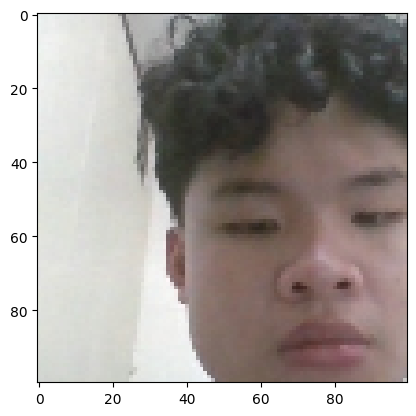

In [224]:
plt.imshow(res[1])

In [236]:

data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size = 1024)

In [177]:
data

<_ShuffleDataset element_spec=((TensorSpec(shape=(100, 100, None), dtype=tf.float32, name=None), TensorSpec(shape=(100, 100, None), dtype=tf.float32, name=None)), TensorSpec(shape=(), dtype=tf.float32, name=None))>

In [49]:
samples = data.as_numpy_iterator()

In [50]:
len(samples.next())

2

In [51]:
samp = samples.next()

In [52]:
samp

((array([[[0.5656863 , 0.55      , 0.54607844],
          [0.5754902 , 0.5598039 , 0.5539216 ],
          [0.5745098 , 0.5588235 , 0.5470588 ],
          ...,
          [0.7107843 , 0.7029412 , 0.7147059 ],
          [0.72083336, 0.7129902 , 0.7247549 ],
          [0.72083336, 0.7129902 , 0.7247549 ]],
  
         [[0.5647059 , 0.54901963, 0.54509807],
          [0.57279414, 0.55710787, 0.5512255 ],
          [0.5833333 , 0.56764704, 0.55588233],
          ...,
          [0.7019608 , 0.69411767, 0.7058824 ],
          [0.7137255 , 0.7058824 , 0.7176471 ],
          [0.7147059 , 0.70686275, 0.71862745]],
  
         [[0.57058823, 0.55490196, 0.5509804 ],
          [0.5764706 , 0.56078434, 0.55490196],
          [0.59411764, 0.57843137, 0.56666666],
          ...,
          [0.7056373 , 0.69779414, 0.70955884],
          [0.7176471 , 0.70980394, 0.72156864],
          [0.722549  , 0.7147059 , 0.7264706 ]],
  
         ...,
  
         [[0.5394608 , 0.5394608 , 0.5394608 ],
          [0.5

In [53]:
samples.next()[1]

1.0

In [54]:
sample = samples.next()
print(type(sample))

<class 'tuple'>


In [115]:
samples.next()[2]

IndexError: tuple index out of range

In [116]:
round(len(data)*.7)

15

In [237]:
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [57]:
train_data

<_PrefetchDataset element_spec=((TensorSpec(shape=(None, 100, 100, None), dtype=tf.float32, name=None), TensorSpec(shape=(None, 100, 100, None), dtype=tf.float32, name=None)), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>

In [58]:
train_samples = train_data.as_numpy_iterator()
train_sample = train_samples.next()

In [151]:
len(train_sample)

2

In [238]:

# Build dataloader pipeline
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=1024)

TypeError: in user code:

    File "C:\Users\Admin\AppData\Local\Temp\ipykernel_10396\336917965.py", line 2, in preprocess_twin  *
        input_img = preprocess(input_img)
    File "C:\Users\Admin\AppData\Local\Temp\ipykernel_10396\4173903600.py", line 2, in preprocess  *
        image = tf.io.read_file(file_path)

    TypeError: Input 'filename' of 'ReadFile' Op has type float32 that does not match expected type of string.


In [239]:
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

In [208]:

# Testing partition
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

4. Model Engineering

4.1 Embedding Layer

In [240]:
def make_embedding():
    inp = Input(shape=(100, 100, 3), name='input_image')
    #block 1
    c1 = Conv2D(64, (10, 10), activation='relu')(inp)
    m1 = MaxPooling2D(64, (2, 2), padding='same')(c1)
    #block 2
    c2 = Conv2D(128, (7, 7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2, 2), padding='same')(c2)
    #block 3
    c3 = Conv2D(128, (4, 4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2, 2), padding='same')(c3)
    #block Embedding
    c4 = Conv2D(256, (4, 4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)

    return Model(inputs=[inp],outputs=[d1], name='embedding')

In [241]:
model = make_embedding()
model.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 100, 100, 3)]     0         
                                                                 
 conv2d_16 (Conv2D)          (None, 91, 91, 64)        19264     
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 46, 46, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_17 (Conv2D)          (None, 40, 40, 128)       401536    
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 20, 20, 128)      0         
 g2D)                                                            
                                                                 
 conv2d_18 (Conv2D)          (None, 17, 17, 128)       26

4.2 Distance Layer

In [121]:
import math

In [122]:
from tensorflow.keras.layers import Layer

In [242]:
class L1Distance(Layer):
    def __init__(self, **kwargs):
        super().__init__()

    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)


In [243]:
l1 = L1Distance()

In [244]:
input_img = Input(name='input_img', shape=(100,100,3))
validation_img = Input(name='validation_img', shape=(100,100,3))

In [245]:
inp_embedding = embedding(input_img)
val_embedding = embedding(validation_img)

In [246]:
print(val_embedding)

KerasTensor(type_spec=TensorSpec(shape=(None, 4096), dtype=tf.float32, name=None), name='embedding/dense_4/Sigmoid:0', description="created by layer 'embedding'")


4.3 Siamese Model

In [247]:
embedding = make_embedding()

In [248]:
def siamese_model():
    #Anchor img input 
    input_image = Input(name='input_img', shape=(100, 100, 3))
    #validation image
    validation_image = Input(name='validation_img', shape=(100, 100, 3))
    #combine siasmese model
    siamese_layer = L1Distance()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image), embedding(validation_image))

    classifier = Dense(1, activation='sigmoid')(distances)
    return Model(inputs=[input_image,validation_image], outputs=classifier, name='SiameseNetwork')




In [249]:
input_img =Input(name='input_img', shape=(100,100,3))
valid_img = Input(name='validation_img', shape=(100,100,3))

input_embedding = embedding(input_img)
valid_embedding = embedding(valid_img)
print(input_embedding)
print(valid_embedding)

KerasTensor(type_spec=TensorSpec(shape=(None, 4096), dtype=tf.float32, name=None), name='embedding/dense_8/Sigmoid:0', description="created by layer 'embedding'")
KerasTensor(type_spec=TensorSpec(shape=(None, 4096), dtype=tf.float32, name=None), name='embedding/dense_8/Sigmoid:0', description="created by layer 'embedding'")


In [250]:
siamese_layer = L1Distance()
siamese_layer(input_embedding, valid_embedding)


<KerasTensor: shape=(None, 4096) dtype=float32 (created by layer 'l1_distance_7')>

In [251]:
Siamese_network = siamese_model()
Siamese_network.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validation_img[0][

5. Training 

5.1 Loss and Optimizer

In [252]:
print(len(batch_1))

2


In [253]:
test_batch = train_data.as_numpy_iterator()
batch_1 = test_batch.next()

X = batch_1[:2]
y = batch_1[2]

In [254]:
y

array([0., 1., 0., 1., 1., 0., 1., 1., 0., 1., 0., 1., 0., 0., 0.],
      dtype=float32)

In [255]:
binary_cross_loss = tf.losses.BinaryCrossentropy()

In [256]:
opt = tf.keras.optimizers.Adam(1e-4)


5.2 Checkpoints

In [257]:
print(type(Siamese_network))

<class 'keras.engine.functional.Functional'>


In [258]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir,'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=Siamese_network)

5.3 Train Step Function

In [259]:
test_batch = train_data.as_numpy_iterator()
batch1 = test_batch.next()
print(len(batch1))

3


In [146]:
print(type(batch_1))

<class 'tuple'>


In [145]:
count = sum(1 for _ in batch_1)
print(count)

2


In [203]:
print(batch_1)

((array([[[[0.5656863 , 0.55      , 0.54607844],
         [0.5754902 , 0.5598039 , 0.5539216 ],
         [0.5745098 , 0.5588235 , 0.5470588 ],
         ...,
         [0.7107843 , 0.7029412 , 0.7147059 ],
         [0.72083336, 0.7129902 , 0.7247549 ],
         [0.72083336, 0.7129902 , 0.7247549 ]],

        [[0.5647059 , 0.54901963, 0.54509807],
         [0.57279414, 0.55710787, 0.5512255 ],
         [0.5833333 , 0.56764704, 0.55588233],
         ...,
         [0.7019608 , 0.69411767, 0.7058824 ],
         [0.7137255 , 0.7058824 , 0.7176471 ],
         [0.7147059 , 0.70686275, 0.71862745]],

        [[0.57058823, 0.55490196, 0.5509804 ],
         [0.5764706 , 0.56078434, 0.55490196],
         [0.59411764, 0.57843137, 0.56666666],
         ...,
         [0.7056373 , 0.69779414, 0.70955884],
         [0.7176471 , 0.70980394, 0.72156864],
         [0.722549  , 0.7147059 , 0.7264706 ]],

        ...,

        [[0.5394608 , 0.5394608 , 0.5394608 ],
         [0.5514706 , 0.5534314 , 0.5509804

In [260]:
@tf.function
def train_step(batch):
    with tf.GradientTape() as tape:
        X = batch[:2]
        y = batch[2]
        
    #Foward pass
        yhat = Siamese_network(X, training = True)
    #Calculate loss
        loss = binary_cross_loss(y, yhat)
    print(loss)
    #gradients
    grad = tape.gradient(loss, Siamese_network.trainable_variables)
#calculate updated weights and apply to siamese model
    opt.apply_gradients(zip(grad, Siamese_network.trainable_variables))
    
    return loss

5.4 Training Loop

In [261]:
def train(data, epochs):
    #Loop through epochs
    for e in range(0,epochs):
        print('\n Epoch{}/{}'.format(e, epochs))
        progbar = tf.keras.utils.Progbar(len(data))
    
    # Loop through each batch

        for idx, batch in enumerate(data):
            train_step(batch)
            progbar.update(idx+1)
    #Save checkpoints
        if e % 10 == 0:
            checkpoint.save(file_prefix =checkpoint_prefix)


5.5 Train models

In [264]:
epochs = 30
train(train_data,epochs)


 Epoch0/30
1/1 [==============================] - 14s 14s/step

 Epoch1/30
1/1 [==============================] - 19s 19s/step

 Epoch2/30
1/1 [==============================] - 16s 16s/step

 Epoch3/30
1/1 [==============================] - 18s 18s/step

 Epoch4/30
1/1 [==============================] - 19s 19s/step

 Epoch5/30
1/1 [==============================] - 17s 17s/step

 Epoch6/30
1/1 [==============================] - 19s 19s/step

 Epoch7/30
1/1 [==============================] - 16s 16s/step

 Epoch8/30
1/1 [==============================] - 15s 15s/step

 Epoch9/30
1/1 [==============================] - 19s 19s/step

 Epoch10/30
1/1 [==============================] - 20s 20s/step

 Epoch11/30
1/1 [==============================] - 19s 19s/step

 Epoch12/30
1/1 [==============================] - 20s 20s/step

 Epoch13/30
1/1 [==============================] - 17s 17s/step

 Epoch14/30
1/1 [==============================] - 20s 20s/step

 Epoch15/30
1/1 [=================

6. Evaluate Model

In [265]:
from tensorflow.keras.metrics import Precision, Recall

In [266]:
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

In [267]:
y_hat = Siamese_network.predict([test_input, test_val])


1/1 [==============================] - 1s 692ms/step


In [268]:
[1 if y_hat >0.5 else 0 for preditions in y_hat]

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [269]:
m = Recall()
m.update_state(y_true, y_hat)
m.result().numpy()

1.0

7. Save model

In [280]:
Siamese_network.save('siasmesemodelv2.h5')

In [283]:
siamesemodel = tf.keras.models.load_model('siasmesemodelv2.h5', custom_objects={'L1Distance':L1Distance, 'BinaryCrossEntropy':tf.losses.BinaryCrossentropy})

In [286]:
siamesemodel.predict([test_input, test_val])

1/1 [==============================] - 1s 626ms/step


array([[2.8458494e-04],
       [9.9999756e-01],
       [9.9989969e-01],
       [9.9999881e-01],
       [9.5596879e-05],
       [1.3313370e-05],
       [2.7699670e-04]], dtype=float32)

8. Real Time Function

In [288]:
os.makedirs('application_data/verification_images')

In [289]:
os.listdir(os.path.join('application_data','verification_images'))

[]

In [290]:

os.path.join('application_data', 'input_image', 'input_image.jpg')

'application_data\\input_image\\input_image.jpg'

In [291]:
for image in os.listdir(os.path.join('application_data', 'verification_images')):
    validation_img = os.path.join('application_data', 'verification_images', image)
    print(validation_img)

application_data\verification_images\input_img.jpg


In [304]:
def verify(model, detection_threshold, verification_threshold):
    # Build results array
    results = []
    for image in os.listdir(os.path.join('application_data', 'verification_images')):
        input_img = preprocess(os.path.join('application_data', 'input_image', 'input_img.jpg'))
        validation_img = preprocess(os.path.join('application_data', 'verification_images', image))
        
        # Make Predictions 
        result = model.predict(list(np.expand_dims([input_img, validation_img], axis=1)))
        results.append(result)
    
    # Detection Threshold: Metric above which a prediciton is considered positive 
    detection = np.sum(np.array(results) > detection_threshold)
    
    # Verification Threshold: Proportion of positive predictions / total positive samples 
    verification = detection / len(os.listdir(os.path.join('application_data', 'verification_images'))) 
    verified = verification > verification_threshold
    
    return results, verified

In [307]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    frame = frame[120:120+250,200:200+250, :]
    
    cv2.imshow('Verification', frame)
    
    # Verification trigger
    if cv2.waitKey(10) & 0xFF == ord('v'):
        # Save input image to application_data/input_image folder 
#         hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
#         h, s, v = cv2.split(hsv)

#         lim = 255 - 10
#         v[v > lim] = 255
#         v[v <= lim] -= 10
        
#         final_hsv = cv2.merge((h, s, v))
#         img = cv2.cvtColor(final_hsv, cv2.COLOR_HSV2BGR)

        cv2.imwrite(os.path.join('application_data', 'verification_images', 'input_img.jpg'), frame)
        # Run verification
        results, verified = verify(siamese_model, 0.5, 0.5)
        print(verified)
    
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

In [311]:
results

NameError: name 'results' is not defined